# Survey Clouds

In [1]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
from collections import defaultdict
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from math import log

In [2]:
save_plots = False

## Font Definitions

In [3]:
font = {'family' : 'sans-serif',
        'sans-serif' : 'Arial',
        'size'   : 14}
matplotlib.rc('font', **font)

In [4]:
font_path = "/Library/Fonts/Arial.ttf"

## Color Definitions

In [5]:
dark_blue = "#004070"
light_blue = "#1d8db0"
light_gray = "#afafaf"

## Custom Color Maps

In [6]:
LiBlGr = LinearSegmentedColormap.from_list("LiBlGr", [light_blue,light_gray], N=256, gamma=1.0)
DaBlGr = LinearSegmentedColormap.from_list("DaBlGr", [dark_blue,light_gray], N=256, gamma=1.0)
WhGr = LinearSegmentedColormap.from_list("DaBlGr", ["#ffffff","#999999"], N=256, gamma=1.0)

## Utility Functions

In [7]:
def show_cloud(cloud, title=None, save=False, file_name="cloud.png"):
    plt.figure(figsize=(20,20))
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    if save:
        plt.savefig(file_name, bbox_inches='tight', format="PNG", transparent=True)
    plt.show()

In [8]:
def show_bar_chart(y, labels, title=None, save=False, file_name="bar.png", cmap=None):
    x = range(len(labels))
    color = cmap if cmap else "b"
    plt.figure()#figsize=(5,5))
    bar = plt.bar(x, y, color=color)
    plt.xticks(x, labels, rotation='vertical')
    plt.box(False)
    # remove all x axis tick lines
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True) # labels along the bottom edge are off
    plt.gca().axes.get_yaxis().set_visible(False)
    for rect in bar:
        height = rect.get_height()
        plt.text(
            rect.get_x() + rect.get_width()/2.0, 
            height, 
            '%d' % int(height), 
            ha='center', 
            va='bottom', 
            size=14)
        plt.title(title)
    if save:
        plt.savefig(image_path.format(group), bbox_inches='tight', format="PNG", transparent=True)
    plt.show()

In [9]:
def show_comparison_bar_chart(group_1_dict, group_2_dict):
    fig, ax = plt.subplots(figsize=(10,4))
    width = 0.45 
    
    #sort the dictionary keys alphabetically by driver and unpack into seperate sortd drivers and scores lists
    drivers, scores = zip(*sorted(group_1_dict.items()))
    x = np.arange(len(drivers))
    bar_1 = ax.bar(x, scores, width, color=light_blue, label=group_1_label)

    #sort the dictionary keys alphabetically by driver and unpack into seperate sortd drivers and scores lists
    drivers, scores = zip(*sorted(group_2_dict.items()))
    bar_2 = ax.bar(x + width, scores, width, color=dark_blue, label=group_2_label)

    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(drivers, rotation='vertical')
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
    # remove all x axis tick lines
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True) # labels along the bottom edge are off
    ax.get_yaxis().set_visible(False)
    for rect in bar_1+bar_2:
        height = rect.get_height()
        plt.text(
            rect.get_x() + rect.get_width()/2.0, 
            height,
            '%d' % int(height),
            ha='center', va='bottom',
            size=14)
    fig.legend(loc=1, frameon=False)
    if save_plots:
        plt.savefig("images/bar_both.png", bbox_inches='tight', format="PNG", transparent=True)
    plt.show()

In [10]:
def show_scoring_scales(scorings, x_labels=None, title="title", save_plots=False):
    fig, ax = plt.subplots(figsize=(10,5))
    x_range = 0
    for scoring, label, color, marker in scorings:
        ax.plot(scoring, label=label, color= color, marker=marker)
        x_range = max(x_range, len(scoring))
    ax.set_title(title)
    ax.set_xlabel("Priority")
    ax.set_ylabel("score")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks(range(x_range))
    if x_labels:
        ax.set_xticklabels(x_labels)
    ax.legend(loc=1, frameon=False)
    #plt.tight_layout()
    if save_plots:
        plt.savefig("images/scores.png", bbox_inches='tight', format="PNG", transparent=True)
    plt.show()

## Text Prcessing

In [11]:
with open("interviews.txt") as f:
    servey = f.read()

In [12]:
group_separator = "__NewGroup__\n"
interview_separator = "__NewInterview__\n"
question_separator = "__Question1d__\n"
drivers_separator = "__Drivers__\n"

In [13]:
group_1_label = "group1"
group_2_label = "group2"
group_key = "group{:d}" #Must follow the same structure a s the group labels

In [14]:
scores_dict = {group_1_label:defaultdict(int), group_2_label:defaultdict(int)}

In [15]:
answers_dict = {group_1_label:defaultdict(int), group_2_label:defaultdict(int)}

In [16]:
# the number of drivers was predefined before interview
total_drivers = 10

In [17]:
groups = servey.split(group_separator)

In [18]:
for group_number, group in enumerate(groups):
    interviews = group.split(interview_separator)
    for interview_number, interview in enumerate(interviews):
        answer, drivers = interview.split(drivers_separator)
        drivers = drivers.strip("\n").split("\n")
        # split interview title and question 1 d
        group, answer = answer.split(question_separator)
        # remove leading and trailing newlines before splitting the text into individual anwers
        answer = answer.strip("\n").split("\n")

        # count the phrases in the answers
        for priority, phrase in enumerate(answer):
            answers_dict[group_key.format(group_number+1)][phrase.lower().strip()] += 1

        # calculate the score for the drivers
        for priority, driver in enumerate(drivers):
            # some drivers have the same prioroty
            labels = driver.split("/") 
            for label in labels:
                score =  total_drivers/log(priority+2)# total_drivers-priority
                scores_dict[group_key.format(group_number+1)][label.lower().strip()] += score

## Scoring System

In [19]:
# Plot to visualize the scoring system
driver_range = range(total_drivers) 
priority_labels = list(map(lambda x: x+1, driver_range))

log_scores = list(map(lambda x: total_drivers/log(2+x),driver_range))
linear_scores = list(map(lambda x: total_drivers-x,driver_range))

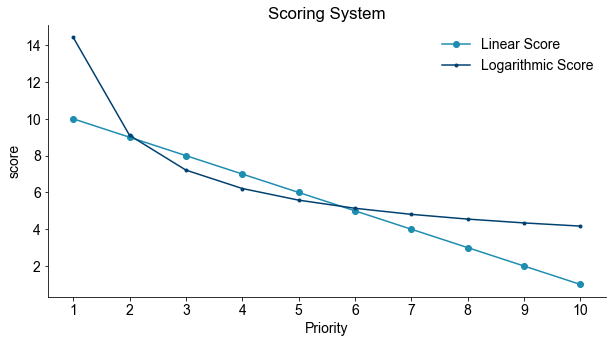

In [20]:
show_scoring_scales(
    [
        (linear_scores,"Linear Score", light_blue, "o" ),
        (log_scores,"Logarithmic Score", dark_blue, ".")
    ], 
    x_labels=priority_labels,
    title="Scoring System",
    save_plots = save_plots
)

## Word Clouds

In [21]:
# shared Word Cloud Settings
background="White" #none for transparent
mode = "RGBA"
width = 1000
height = 500
collocations = False
min_font_size=4
prefer_horizontal=1
relative_scaling=1

In [22]:
mask = np.array(Image.open("cloud-mask.png"))

### Driver Word Clouds

In [23]:
driver_cloud = WordCloud(
    colormap=DaBlGr,
    random_state=25,
    mask=mask,
    background_color=background, 
    mode=mode, 
    collocations=collocations,
    min_font_size=min_font_size,
    prefer_horizontal=prefer_horizontal,
    relative_scaling=relative_scaling,
    font_path=font_path
)

In [24]:
image_path = "images/driver_{:s}.png"

group1


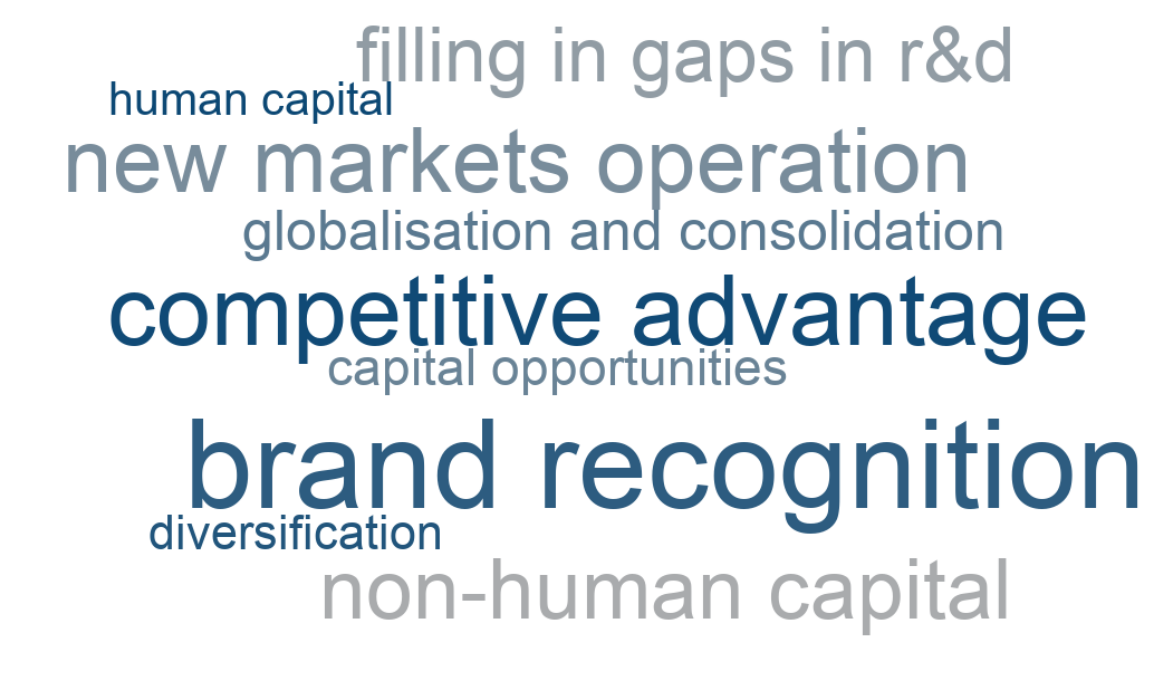

group2


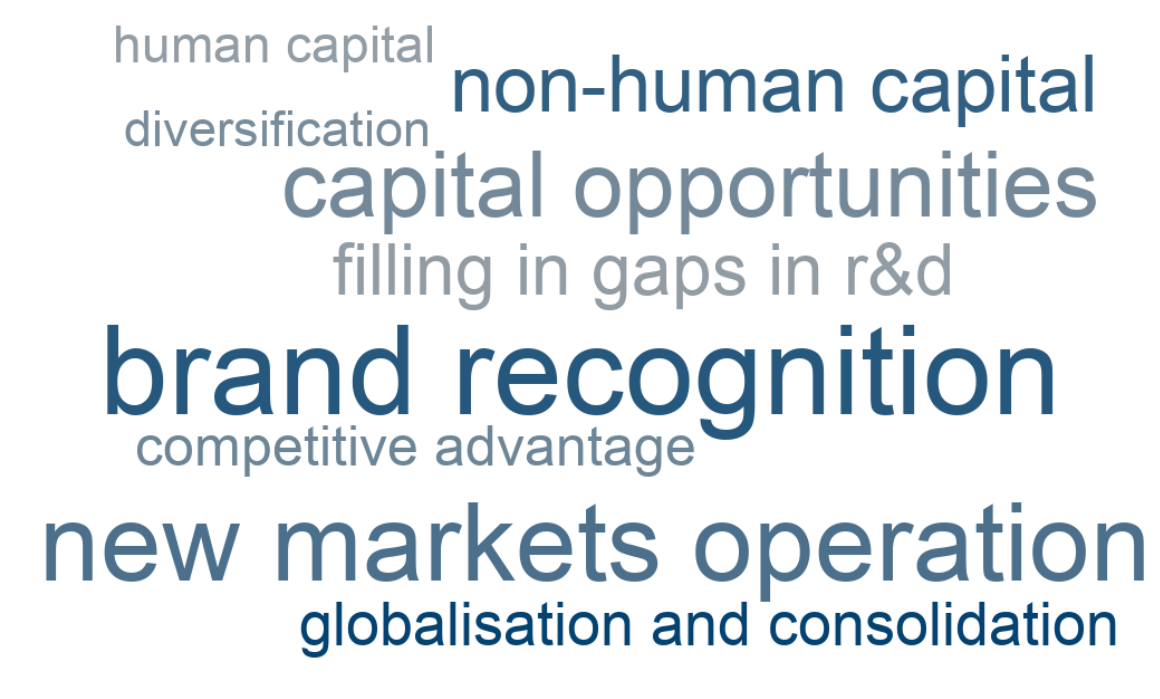

In [25]:
for group, scores in scores_dict.items():
    driver_cloud.generate_from_frequencies(scores)
    print(group)
    show_cloud(driver_cloud, save=save_plots, file_name=image_path.format(group))

### Question Word Clouds

In [26]:
question_cloud = WordCloud(
    colormap=LiBlGr,
    random_state=25,
    mask=mask,
    background_color=background, 
    mode=mode, 
    collocations=collocations,
    min_font_size=min_font_size,
    prefer_horizontal=prefer_horizontal,
    relative_scaling=relative_scaling,
    font_path=font_path
)

In [27]:
image_path = "images/question_{:s}.png"

group1


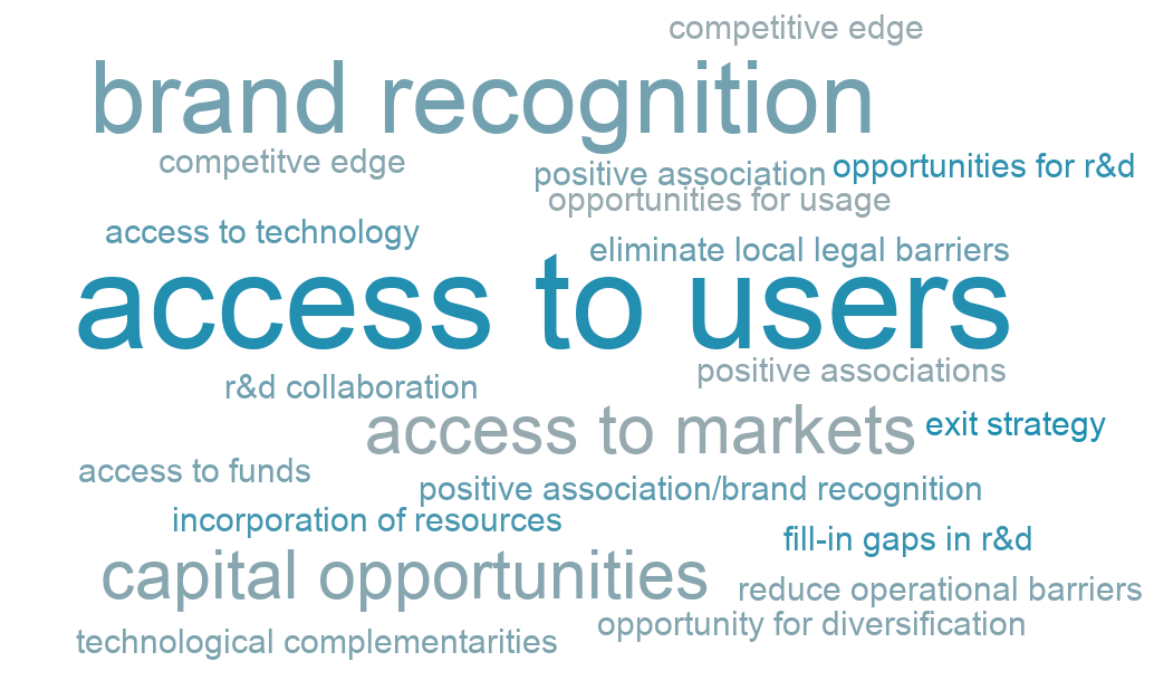

group2


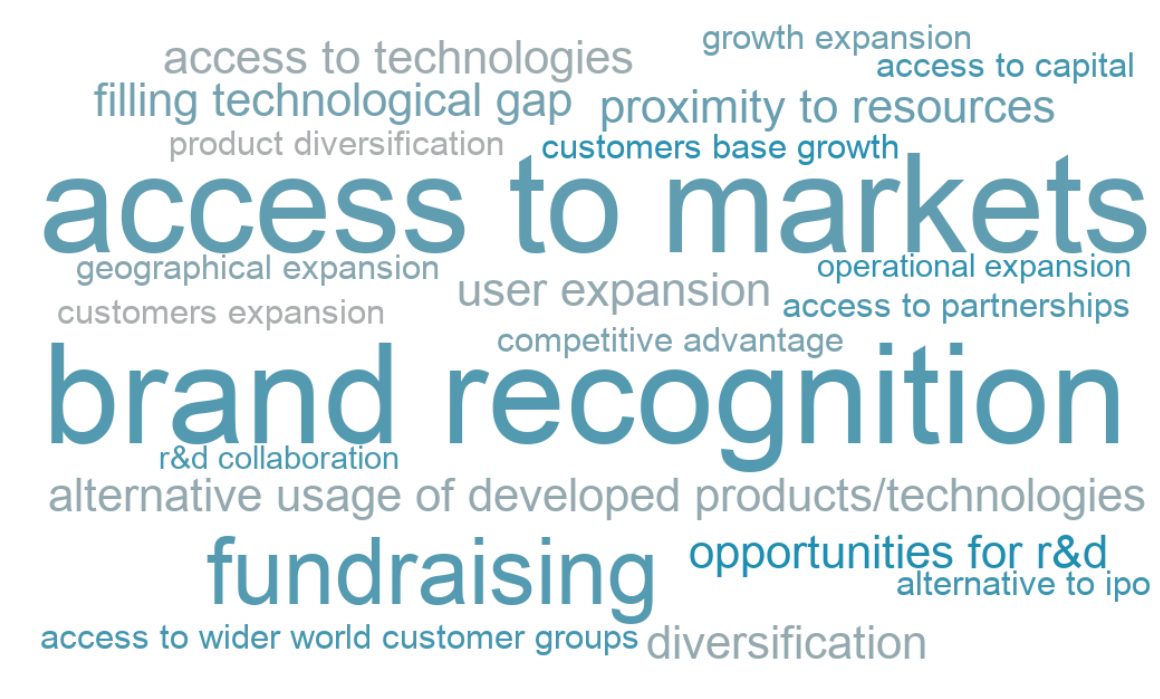

In [28]:
for group, answers in answers_dict.items():
    question_cloud.generate_from_frequencies(answers)
    print(group)
    show_cloud(question_cloud, save=save_plots, file_name=image_path.format(group))

## Driver Graphs

In [29]:
image_path = "images/bar_{:s}.png"

group1


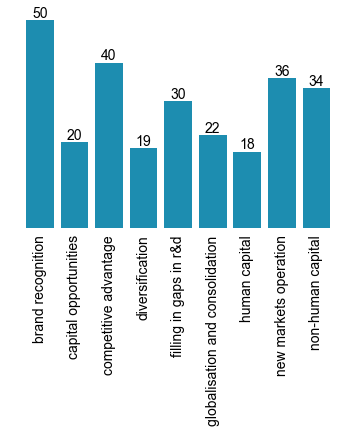

group2


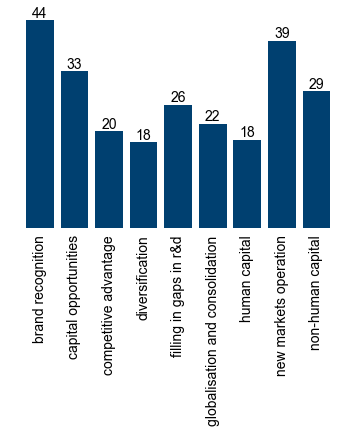

In [30]:
for group, score in scores_dict.items():
    drivers, scores = zip(*sorted(scores_dict[group].items()))
    print(group)
    color = light_blue if group is group_1_label else dark_blue
    show_bar_chart(scores, drivers, save=save_plots, file_name=image_path.format(group), cmap=color)

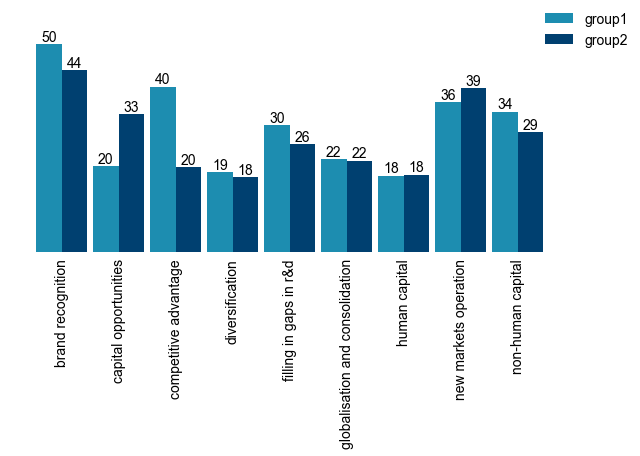

In [31]:
show_comparison_bar_chart(scores_dict[group_1_label], scores_dict[group_2_label])

## Portfolio Thumbnail

In [32]:
portfolio_cloud = WordCloud(
    colormap=WhGr,
    random_state=25,
    mask=mask,
    background_color=None, 
    mode=mode, 
    collocations=collocations,
    min_font_size=min_font_size,
    prefer_horizontal=prefer_horizontal,
    relative_scaling=relative_scaling,
    font_path=font_path
)

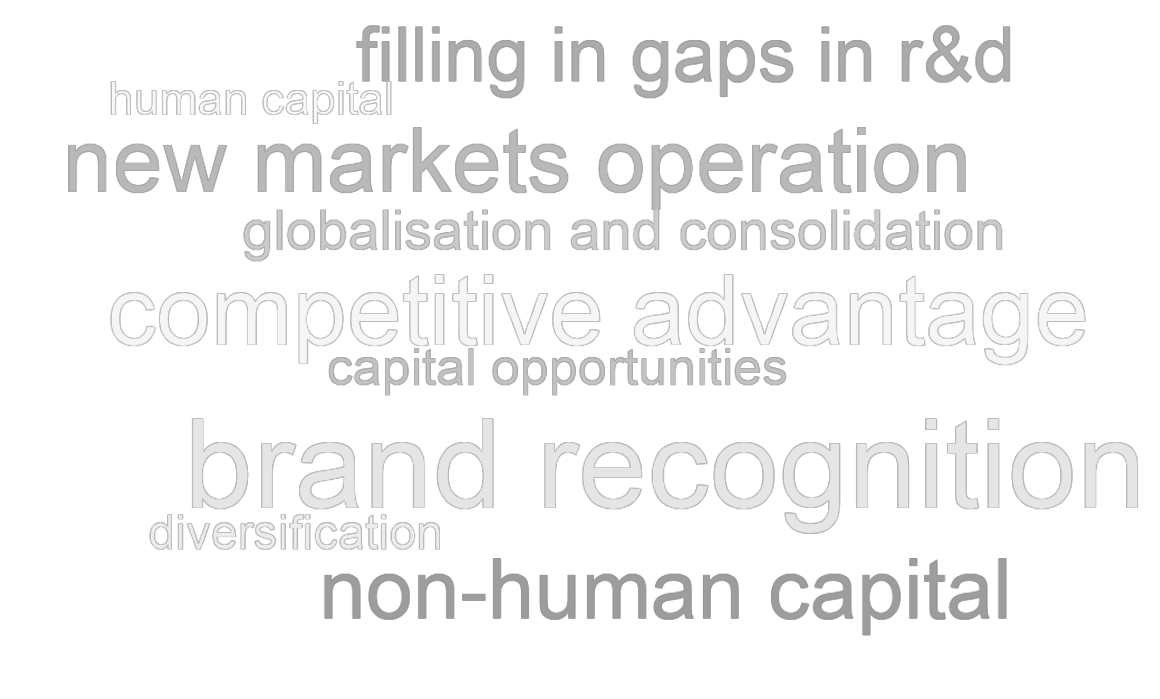

In [33]:
group, scores = list(scores_dict.items())[0]
portfolio_cloud.generate_from_frequencies(scores)
show_cloud(portfolio_cloud, save=True, file_name="images/PortfolioCloud.png")